In [2]:
# Author: Alkistis Pourtsidou, ICG Portsmouth
# Using part of http://camb.readthedocs.io/en/latest/CAMBdemo.html 

# To run this notebook you need to have CAMB and the CAMB python package 
# installed. In order to install the CAMB python package on your computer follow
# the instructions in http://camb.readthedocs.io/en/latest/

%matplotlib inline
import sys, platform, os

from matplotlib import pyplot as plt
import numpy as np
#print('Using CAMB installed at '+ os.path.realpath(os.path.join(os.getcwd(),'..')))
#sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower

In [3]:
import pylab as pl

In [4]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['legend.fontsize']='medium'

In [5]:
import scipy
from scipy.interpolate import interp1d
from __future__ import division

In [6]:
from scipy import integrate
from scipy import linalg

pi=np.pi

In [7]:
#Fiducial cosmological parameters
c=3e5
hubble=0.678
omegab=0.022*pow(hubble,-2)
omegac=0.119*pow(hubble,-2)
om0=omegac+omegab
H00=100*hubble
Ass=2.14e-9
nss = 0.968

gamma=0.545

print om0

0.306732450988


In [8]:
#Set up the fiducial cosmology
pars = camb.CAMBparams()
#Set cosmology
pars.set_cosmology(H0=H00, ombh2=omegab*pow(hubble,2), omch2=omegac*pow(hubble,2),omk=0,mnu=0)
pars.set_dark_energy() #LCDM (default)
pars.InitPower.set_params(ns=nss, r=0, As=Ass)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [9]:
#calculate results for these parameters
results = camb.get_results(pars)

In [10]:
#Get matter power spectrum at z=0: P(k,z=0)

#Not non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0.], kmax=2.0)

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 200)

In [11]:
#Construct P(k,z=0) interpolating function, in units of Mpc (no h)
Pkz0 = interp1d(kh*hubble, pk[0]/pow(hubble,3))

In [13]:
#Redshift bins
zlist = np.arange(0.1,1.45,0.1)
ztest = zlist[4]
Nzbins = len(zlist)

print zlist
print "ztest =", ztest
print "Number of redshift bins =", Nzbins

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4]
ztest = 0.5
Number of redshift bins = 14


In [14]:
#Define E(z) = H(z)/H0
def Ez(zc):
    return np.sqrt(1-om0+om0*pow(1+zc,3))
#Define the comoving distance
def drdz(zp):
    return (c/H00)/Ez(zp)
def rcom(zc):
    return scipy.integrate.romberg(drdz,0,zc)

print rcom(ztest)

1946.72577762


In [15]:
#Define the growth function in LCDM
def get_growth(zz):
    omz=om0*pow(1+zz,3)/(om0*pow(1+zz,3)+1-om0)
    return pow(omz,gamma)

print get_growth(ztest)

0.756249102937


In [16]:
#Get the growth factor 
def Dg_dz(zz):
    return get_growth(zz)/(1+zz)
def Dgz(zc):
    ans = scipy.integrate.romberg(Dg_dz, 0.0, zc)
    return np.exp(-ans)

print Dgz(ztest)

0.770149045252


In [17]:
#fiducial bHI from Bull et al 2015
def bHI(zc):
    return 0.67+0.18*zc+0.05*pow(zc,2)

#fiducial OmHI from Crighton et al 2015
def OmHI(zc):
    return 0.0004*pow(1+zc,0.6)

print OmHI(ztest), bHI(ztest)

0.00051016980025 0.7725


In [18]:
#Construct P(k,z) 
def Pkz(kk,zc):    
    return pow(Dgz(zc),2)*Pkz0(kk)

print Pkz(0.1,ztest)

6983.67990574


In [20]:
#mean brightness temperature [mK]
def Tb(zc):
    return 180.*OmHI(zc)*hubble*pow(1+zc,2)/Ez(zc)

print Tb(ztest)

0.106553098208


In [21]:
#Construct P_HI(k,z) [mK^2]
def PHI(kk,zc):
    return pow(Tb(zc),2)*pow(bHI(zc),2)*Pkz(kk,zc)

In [22]:
#MeerKAT noise specs
Ndishes=64
Ddish=13.5*100 #cm
Nbeams=1

def thetab(zc):
    return 21*(1+zc)/Ddish

def omegapix(zc):
    return 1.13*pow(thetab(zc),2)

Area=5000.0 #deg^2
fsky=Area/44000
omegatot = Area*pow(pi/180,2) #sr^2
ttotal = 3650*60*60 #approx 5 months in sec

Tsyslist = [23.5*1e3,23.0*1e3,23.0*1e3,28.0*1e3,29.0*1e3,30.0*1e3,28.5*1e3,29.5*1e3,\
            31.0*1e3,33.0*1e3,34.0*1e3,35.0*1e3,37.0*1e3,38.0*1e3] #mK

def tobs(zc):
    return ttotal*(omegapix(zc)/omegatot)*Ndishes*Nbeams

Dzbin = 0.1
dfpix = 50*1e3 #Hz
midfreq = 1420.4e6 #Hz

def dzpix(zc):
    return (1+zc)*dfpix/midfreq
def sigpix(zc,Tsys):
    return Tsys/np.sqrt(dfpix*tobs(zc)) 
def dVpixdz(zz):    
    return c*pow(rcom(zz),2)/(H00*Ez(zz))
def Vpix(zc):
    return omegapix(zc)*scipy.integrate.romberg(dVpixdz,zc-dzpix(zc)/2,zc+dzpix(zc)/2)

def Wsq(kk,zc):
    return np.exp(-pow(kk,2)*pow(rcom(zc),2)*pow(thetab(zc),2)/(8*np.log(2)))

def Pnoise(kk,zc,Tsys):
    return pow(sigpix(zc,Tsys),2)*Vpix(zc)*pow(Wsq(kk,zc),-1.)

In [24]:
def kmin(zc):
    return 2*pi/np.sqrt(pow(rcom(zc),2)*omegatot)
def kmax(zc):
    return 0.14*pow(1+zc,2/(2+nss)); #non-linear cutoff Smith et al 2003
    #return 2*pi*Ddish/(rcom(zc)*21*(1+zc)) #instrumental cutoff

print kmin(ztest), kmax(ztest)

0.00261524703843 0.18398732861


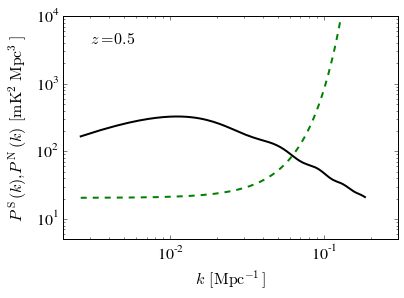

In [25]:
#Plot HI signal and noise power spectra
k1 = np.linspace(kmin(ztest),kmax(ztest),200)
pk1 = [PHI(k,ztest) for k in k1]
pn1 = [Pnoise(k,ztest,Tsyslist[4]) for k in k1]

plt.loglog(k1,pk1,color='black',lw=2)
plt.loglog(k1,pn1,color='green',lw=2,ls='dashed')

plt.xlim(2e-3, 0.3)
plt.ylim(5, 1e4)

plt.xlabel("$k \, \mathrm{[Mpc^{-1}]}$")
plt.ylabel("$P^{\, \mathrm{S}}(k), P^{\, \mathrm{N}}(k)  \, \mathrm{[mK^2 Mpc^3]}$")

pl.text(3e-3, 4e3, '$z=0.5$')

#pl.savefig('PS_PN.pdf', format="pdf", bbox_inches = 'tight')
plt.show()

In [26]:
#survey (bin) volume [Mpc^3]
def dVsurdz(zz):    
    return omegatot*c*pow(rcom(zz),2)/(H00*Ez(zz))
    
def Vsur(zc):
    return scipy.integrate.romberg(dVsurdz,zc-Dzbin/2,zc+Dzbin/2)

#effective volume going in the Fisher matrix
def Veff(kk,zc):
    return Vsur(zc)*(PHI(kk,zc)/(PHI(kk,zc)+Pnoise(kk,zc,Tsys)))**2

print "%.4g" % Vsur(ztest)

1.943e+09


In [27]:
#Fisher matrix derivatives

def dlnP_dlnOmHIbHI(kk,zc):
    return 2.0

In [28]:
#Fisher matrix

def dFdk(kk):
    return (1./(4*pi*pi))*pow(kk,2)*pow(dlnP_dlnOmHIbHI(kk,zc),2)*Veff(kk,zc)

In [29]:
for i in range(0,Nzbins):
    zc = zlist[i]
    Tsys = Tsyslist[i]
    K = np.linspace(kmin(zc), kmax(zc), 500)
    dF = dFdk(K)
    Fisher = scipy.integrate.simps(dF,K)           
    print zc, np.sqrt(1/Fisher)

0.1 0.0087366539237
0.2 0.0051613910422
0.3 0.00545330346584
0.4 0.00780044878205
0.5 0.00963869847628
0.6 0.0115838246039
0.7 0.0129396838023
0.8 0.0152590740051
0.9 0.0180107469804
1.0 0.0212159983565
1.1 0.0241540411944
1.2 0.027276181762
1.3 0.0312659569882
1.4 0.0349157710215
